#Mutual Information Estimation Example Notebook

In [ ]:
!git clone https://github.com/Linear95/CLUB

Cloning into 'CLUB'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 114 (delta 52), reused 72 (delta 26), pack-reused 0
Receiving objects: 100% (114/114), 601.49 KiB | 2.81 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
%cd CLUB

/content/CLUB


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '2'

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

Our NCE-CLUB estimator. The ```forward``` method computes the CLUB objective and the ```learning_loss``` method computes the InfoNCE objective.

In [ ]:
class CLUBInfoNCE(nn.Module):
    def __init__(self, x_dim, y_dim, hidden_size):
        super(CLUBInfoNCE, self).__init__()
        self.F_func = nn.Sequential(nn.Linear(x_dim + y_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1),
                                    nn.Softplus())

    def forward(self, x_samples, y_samples):
        sample_size = y_samples.shape[0]

        x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
        y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

        T0 = self.F_func(torch.cat([y_samples,x_samples], dim = -1))
        T1 = self.F_func(torch.cat([y_tile, x_tile], dim = -1))  #[sample_size, sample_size, 1]

        return T0.mean() - T1.mean()

    def learning_loss(self, x_samples, y_samples):
        sample_size = y_samples.shape[0]

        x_tile = x_samples.unsqueeze(0).repeat((sample_size, 1, 1))
        y_tile = y_samples.unsqueeze(1).repeat((1, sample_size, 1))

        T0 = self.F_func(torch.cat([x_samples,y_samples], dim = -1))
        T1 = self.F_func(torch.cat([x_tile, y_tile], dim = -1))  #[sample_size, sample_size, 1]

        lower_bound = T0.mean() - (T1.logsumexp(dim = 1).mean() - np.log(sample_size))
        return -lower_bound

# Mutual Information Estimation

We compare the NCE-CLUB estimator with other baselines on MI estimation quality using samples drawn from Gaussian distributions with the known groundtruth MI. The code is adapted from https://github.com/Linear95/CLUB

Sampling function for Gaussian data with the given [correlation coefficient](https://en.wikipedia.org/wiki/Mutual_information#Linear_correlation) $\rho$:

In [ ]:
def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128, to_cuda=False, cubic = False):
    """Generate samples from a correlated Gaussian distribution."""
    mean = [0,0]
    cov = [[1.0, rho],[rho, 1.0]]
    x, y = np.random.multivariate_normal(mean, cov, batch_size * dim).T

    x = x.reshape(-1, dim)
    y = y.reshape(-1, dim)

    if cubic:
        y = y ** 3

    if to_cuda:
        x = torch.from_numpy(x).float().cuda()
        #x = torch.cat([x, torch.randn_like(x).cuda() * 0.3], dim=-1)
        y = torch.from_numpy(y).float().cuda()
    return x, y

In [ ]:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho **2)
    return result


def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

In [ ]:
sample_dim = 20
batch_size = 64
hidden_size = 512
learning_rate = 0.005
training_steps = 4000

cubic = False
model_list = ["InfoNCE", "CLUB", "CLUBInfoNCE"]
legend_map = {"InfoNCE": r'$NCE$', "CLUB": r'$CLUB$', "CLUBInfoNCE": r'$NCE-CLUB$'}
mi_list = [2.0, 4.0, 6.0, 8.0, 10.0]

total_steps = training_steps*len(mi_list)

###Gaussain experiments

In [ ]:
# train MI estimators with samples
from mi_estimators import *

sample_dims = [20, 50, 100, 200]
gaussian_results = [dict() for _ in range(4)]
for j in range(len(gaussian_results)):

    mi_results = gaussian_results[j]
    sample_dim = sample_dims[j]
    for i, model_name in enumerate(model_list):

        model = eval(model_name)(sample_dim, sample_dim, hidden_size).cuda()
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

        mi_est_values = []

        start_time = time.time()
        for i, mi_value in enumerate(mi_list):
            rho = mi_to_rho(mi_value, sample_dim)

            for step in range(training_steps):
                batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size = batch_size, to_cuda = True, cubic = cubic)

                model.eval()
                mi_est_values.append(model(batch_x, batch_y).item())

                model.train()

                model_loss = model.learning_loss(batch_x, batch_y)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()

                del batch_x, batch_y
                torch.cuda.empty_cache()

            print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
            # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))
            torch.cuda.empty_cache()
        end_time = time.time()
        time_cost = end_time - start_time
        print("model %s average time cost is %f s" % (model_name, time_cost/total_steps))
        mi_results[model_name] = mi_est_values

finish training for InfoNCE with true MI value = 2.000000
finish training for InfoNCE with true MI value = 4.000000
finish training for InfoNCE with true MI value = 6.000000
finish training for InfoNCE with true MI value = 8.000000
finish training for InfoNCE with true MI value = 10.000000
model InfoNCE average time cost is 0.004848 s
finish training for CLUB with true MI value = 2.000000
finish training for CLUB with true MI value = 4.000000
finish training for CLUB with true MI value = 6.000000
finish training for CLUB with true MI value = 8.000000
finish training for CLUB with true MI value = 10.000000
model CLUB average time cost is 0.002770 s
finish training for CLUBInfoNCE with true MI value = 2.000000
finish training for CLUBInfoNCE with true MI value = 4.000000
finish training for CLUBInfoNCE with true MI value = 6.000000
finish training for CLUBInfoNCE with true MI value = 8.000000
finish training for CLUBInfoNCE with true MI value = 10.000000
model CLUBInfoNCE average time co

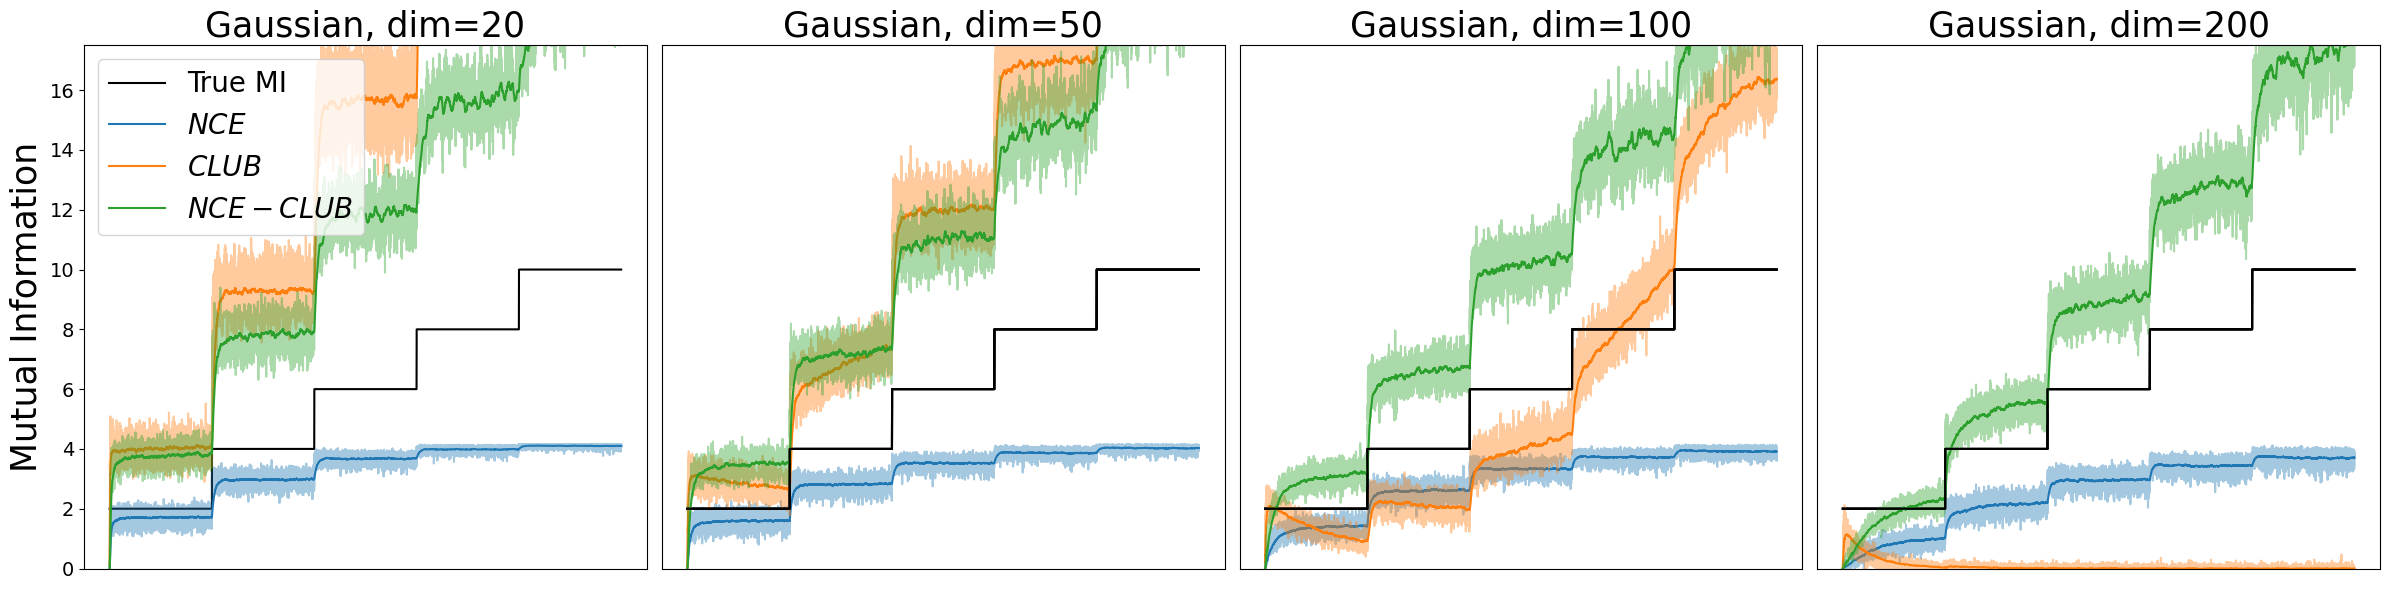

In [ ]:
import seaborn as sns
import pandas as pd
colors = sns.color_palette()

EMA_SPAN = 200

ncols = len(gaussian_results)
nrows = 1
#fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 *ncols , 3.4 * nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(6 *ncols , 6 * nrows))
axs = np.ravel(axs)


xaxis = np.array(list(range(total_steps)))
yaxis_mi = np.repeat(mi_list, training_steps)

#for i, model_name in enumerate(model_list):
for i in range(ncols):
    mi_results = gaussian_results[i]
    dim = sample_dims[i]
    plt.sca(axs[i])
    plt.plot(yaxis_mi, color='k', label='True MI')
    for j, model_name in enumerate(model_list):
        p1 = plt.plot(mi_results[model_name], alpha=0.4, color=colors[j])[0]  #color = 5 or 0
        mis_smooth = pd.Series(mi_results[model_name]).ewm(span=EMA_SPAN).mean()

        if i == 0:
            plt.plot(mis_smooth, c=p1.get_color(), label=legend_map[model_name])
            #plt.xlabel('Steps', fontsize= 25)
            plt.ylabel('Mutual Information', fontsize = 25)
            plt.legend(loc='upper left', prop={'size':20})
        else:
            plt.plot(mis_smooth, c=p1.get_color())
            plt.yticks([])
            plt.plot(yaxis_mi, color='k')
            plt.xticks([])

    plt.ylim(0, 17.5)
    #plt.xlim(0, total_steps)
    plt.title(f'Gaussian, dim={dim}', fontsize=25)
    #plt.xticks(fontsize=14)
    plt.xticks([])
    plt.yticks(fontsize=14)
    #plt.subplots_adjust( )

plt.gcf().tight_layout()
plt.savefig('mi_est_Gaussian.pdf', bbox_inches=None)